# Working out how to detect faces in a live video

## Imports

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

Import Haarcascade

In [2]:
face_cascade = cv2.CascadeClassifier('DATA/haarcascades/haarcascade_frontalface_default.xml')

## Helper funcs

In [3]:
def return_largest(a,b):
    """Compare a,b and reutrn largest"""
    
    def calculate_delta(x):
        """calculate the size of face"""
        _,_,w,h = x
        return w * h
    
    if calculate_delta(a) > calculate_delta(b):
        return a
    else:
        return b

Function to detect face

In [4]:
def detect_face(img):
  
    face_img = img.copy()
  
    face_rects = face_cascade.detectMultiScale(face_img) 
    
    for (x,y,w,h) in face_rects: 
        cv2.rectangle(face_img, (x,y), (x+w,y+h), (255,255,255), 10) 
        
    return face_img

Detect adjacent faces with single boxes

In [5]:
def adj_detect_face(img):
    """Dectect faces in an image with no overlaps
    Arg img: an image
    
    Result: 
    face_img = image with bounding boxes
    face-rects = array of arrays, each array is corners of face bounding box
    """
    
    
    face_img = img.copy()
  
    face_rects = face_cascade.detectMultiScale(face_img,scaleFactor=1.2, minNeighbors=5) 
    
    for (x,y,w,h) in face_rects: 
        cv2.rectangle(face_img, (x,y), (x+w,y+h), (255,255,255), 10) 
        
    return face_img, face_rects

In [6]:
def adj_detect_largest_face(img):
    """Dectect largest face in image
    Arg img: an image
    img: image with bounding box on largest face
    largest: array containing the coords of largest face (in regards to image)
    center: center location of face in image
    """
    largest = [0,0,0,0]
    center = [0,0] #init as center of screen
    
    face_img = img.copy()
  
    face_rects = face_cascade.detectMultiScale(face_img,scaleFactor=1.2, minNeighbors=5) 
    
    #if len(face_rects) > 1: # only one face so unpack it
    #    x,y,w,h = face_rect[0]
    #    center = x+w,y+h
    #else: #find largest face
    for x,y,w,h in face_rects:
        # print(f"{largest=}: {type(largest)}")
        largest = return_largest(largest,[x,y,w,h])
        # print(f"{largest=}: {type(largest)}")
    # once largest found sent center
    x,y,w,h = largest
    center = int(x+w/2), int(y+h/2) # assumes correct ordering (safe assumption)
    
    
    # # uncomment to draw box
    for (x,y,w,h) in [largest]:
        cv2.rectangle(face_img, (x,y), (x+w,y+h), (255,255,255), 10) 
    # # uncomment to mark center
    # ToDo for sanity checks
        
    return face_img, largest, center

## Testing

In [7]:
horus = cv2.imread('DATA/livingstone.jpg',0)
solvay = cv2.imread('DATA/solvay_conference.jpg',0)

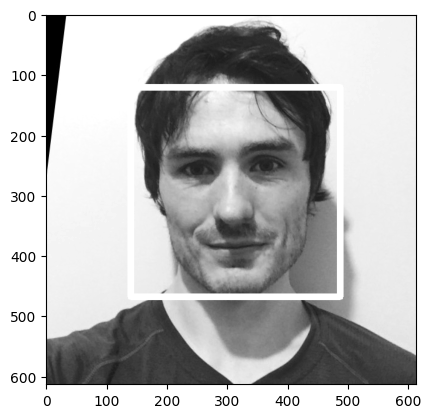

In [8]:
result = detect_face(horus)
plt.imshow(result,cmap='gray')

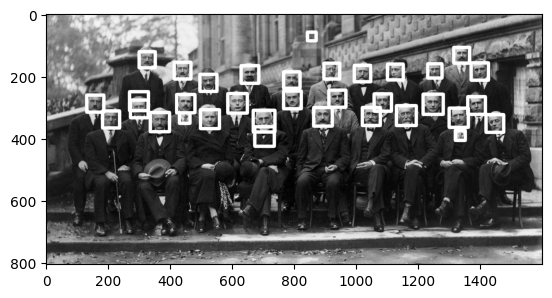

In [9]:
result = detect_face(solvay)
plt.imshow(result,cmap='gray')

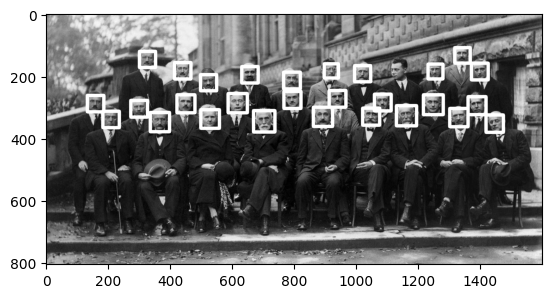

In [10]:
# Doesn't detect the side face.
result, _ = adj_detect_face(solvay)
plt.imshow(result,cmap='gray')

largest=[139, 121, 344, 344]: <class 'list'>
center=(311, 293): <class 'tuple'>


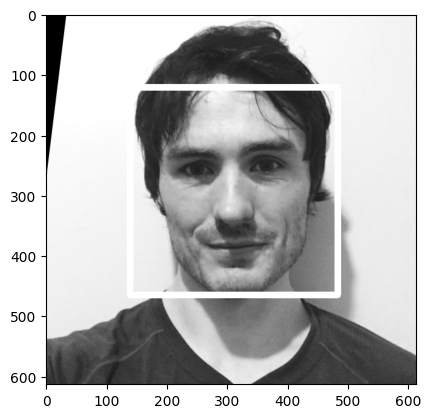

In [11]:
result, largest, center = adj_detect_largest_face(horus)
plt.imshow(result,cmap='gray')
print(f"{largest=}: {type(largest)}")
print(f"{center=}: {type(center)}") # x then y, x is left 0 to right inf, y is top 0 down to inf

## Run with default camera making bounding box on faces

#warning this needs force quitting in macOS

cap = cv2.VideoCapture(0) 

while True: 
    
    ret, frame = cap.read(0) 
     
    #frame = detect_face(frame)
    #frame, face_rects = adj_detect_face(frame)
    #if len(face_rects) > 1:
    #    print(face_rects)
    
    frame, largest, center = adj_detect_largest_face(frame)
    #print(largest, center)
 
    cv2.imshow('Video Face Detection', frame) 
    #print(np.shape(frame))
 
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
cap.release()
cv2.destroyAllWindows()

# Load in background image

In [12]:
hobbit = cv2.imread('DATA/hobbiton.jpeg')

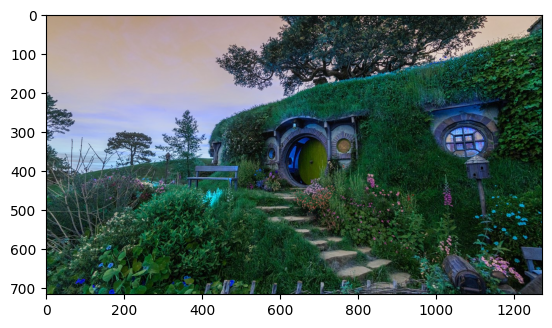

In [13]:
plt.imshow(hobbit)

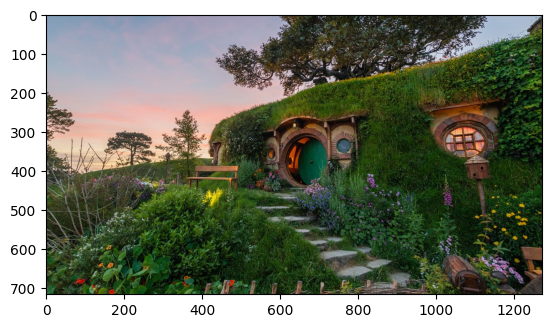

In [14]:
hobbit_rgb=cv2.cvtColor(hobbit, cv2.COLOR_BGR2RGB)
plt.imshow(hobbit_rgb)

In [15]:
def load_background(file):
    """
    loads an image using cv2, I just wanted a function instead of writing cv.load :P
    CAUTION! cv2 loads as brg, if you wnt to display in plt.imshow, first cast to rgb cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    args: 
    file: String containing path/filename.extn, example 'DATA/hobbiton.jpeg'
    
    return: np array, should be (m,n,3) but see cv2.imread() for docs
    """
    return cv2.imread(file)

# Get a slice from image

In [35]:
def slicer(img, coords, debug=False):
    """
    Slices out a rectangular sub array from an image
    
    args:
    img: np array (m,n,3)
    coords: 4 tuple containing corner co-ords to slice (x1,x2,y1,y2)
    debug: bool, True to display debug info
    
    return:
    img_slice: np array (m,n,3)
    """
    x1,x2,y1,y2 = coords
    img_shape = np.shape(img)
    
    # Check we are not trying to slice outside of ary
    # TODO, this is probs pretty shitty compute wise on every frame....
    if x1 < 0 or y1 < 0:
        raise Exception(f"Sorry, cannot slice below 0, out of array range, {x1=}, {y1=}") 
        
    if x2 > img_shape[1] or y2 > img_shape[0]:
        if debug: #switch "debug" param to turn debugging on/off
            print(f"img: {np.shape(img)},  {coords=}")
            print(f"{y2 > img_shape[0]}, y2 > img_shape[0], y2 = {y2} and img = {img_shape[0]}  ")
            print(f"{x2 > img_shape[1]}, x2 > img_shape[1], x2 = {x2} and img = {img_shape[1]}  ")
        raise Exception(f"Sorry, cannot slice out of range, {img_shape=}, {x2=}, {y2=}") 
    
    #swap x/y around as np/cv is weird with images
    img_slice = img[y1:y2, x1:x2]
    
    return img_slice

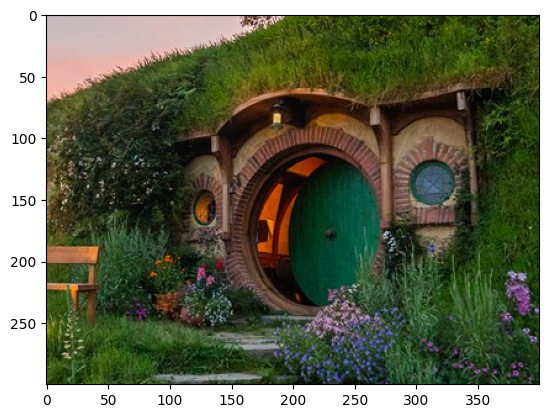

In [36]:
hobbit_rgb_slice = slicer(hobbit_rgb, (450,850, 200,500))
plt.imshow(hobbit_rgb_slice)

In [44]:
def invert(length, place):
    """inverts 1 d location bound between 0 - length and normalizes to 0-1"""
    # invert in 1D plane
    new = length - place
    # normalize 0-1 
    normal = new / length
    return normal


def slice_calculator(original_img_shape, target_img_shape, center=False, window=(100,100)):
    """
    Takes two image shapes, returns a slice coords to slice target 
    where the shape slides in inverse to viewer
    Needs better description here.....
    
    args:
        original_img_shape: np.shape tuple of original image
        target_img_shape: np.shape tuple of target image
        center: tuple (x,y) indicating center of user face location on original_img
        window: tuple (width, height) indicates the height and width of slice (set for monitor rez)
    
    return:
        slice_coords: 4 tuple containing corner co-ords to slice (x1,x2,y1,y2)
    """
    #if not center present use true center
    if not center:
        center = (original_img_shape[0]/2, original_img_shape[1]/2)
    
    half_window_x = window[0] / 2
    half_window_y = window[1] / 2
    
    # get x,y normalised locations (we are floats)
    x_scalar = invert(original_img_shape[0], center[0])
    y_scalar = invert(original_img_shape[1], center[1])

    # Making sure we dont og off the ends
    viable_x = target_img_shape[0] - window[0]
    viable_y = target_img_shape[1] - window[1]
    
    # get x's
    x1 = int(0 + viable_x * x_scalar)
    x2 = int(x1 + half_window_x * 2) - 1
    # get y's
    y1 = int(0 + viable_y * y_scalar)
    y2 = int(y1 + half_window_y * 2) - 1

    print(x1, x2, y1, y2)
    
    # slice_coords = (x1,x2,y1,y2)
    slice_coords = (y1,y2,x1,x2)
    #print(f"whut am i??? {slice_coords=}, type: {type(slice_coords)}")
    
    return slice_coords


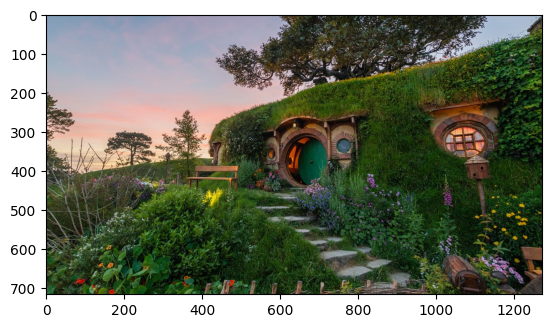

In [45]:
hobbit_rgb=cv2.cvtColor(hobbit, cv2.COLOR_BGR2RGB)
plt.imshow(hobbit_rgb)

# Below test shows a detected face in bottom right, user gets top left

0 99 0 99


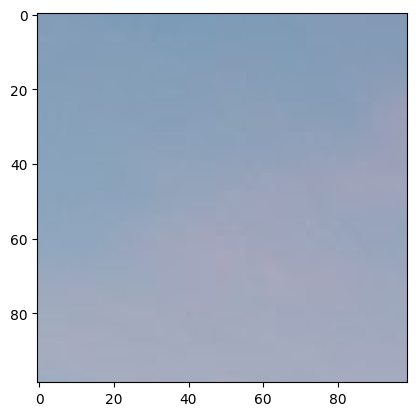

In [46]:
#result, _, center = adj_detect_largest_face(horus)
original_img_shape = (720, 1280, 3) # hard coded for my macbooks camera
target_img_shape = np.shape(hobbit)

slice_coords = slice_calculator(original_img_shape, target_img_shape, center=(720, 1280), window=(100,100))

sliced_hobits = slicer(hobbit_rgb, slice_coords, debug=True)

plt.imshow(sliced_hobits)

258 457 1072 1271


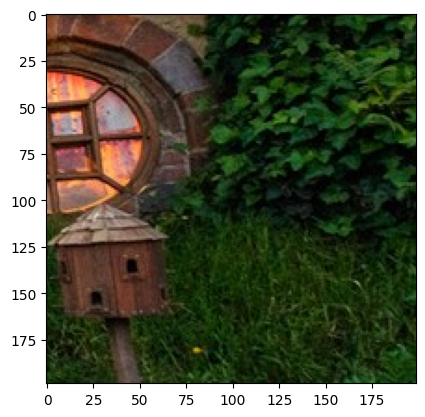

In [47]:
#result, _, center = adj_detect_largest_face(horus)
original_img_shape = (720, 1280, 3) # hard coded for my macbooks camera
target_img_shape = np.shape(hobbit)

slice_coords = slice_calculator(original_img_shape, target_img_shape, center=(360, 0), window=(200,200))

sliced_hobits = slicer(hobbit_rgb, slice_coords, debug=True)

plt.imshow(sliced_hobits)

258 457 536 735


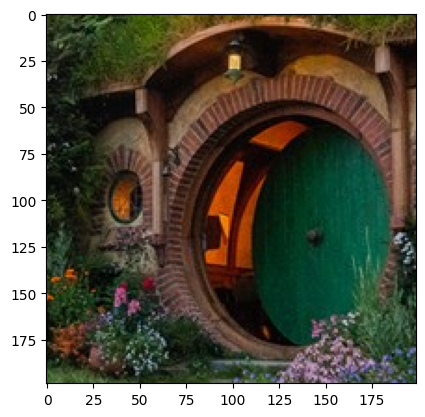

In [48]:
#result, _, center = adj_detect_largest_face(horus)
original_img_shape = (720, 1280, 3) # hard coded for my macbooks camera
target_img_shape = np.shape(hobbit)

slice_coords = slice_calculator(original_img_shape, target_img_shape, center=(360, 640), window=(200,200))

sliced_hobits = slicer(hobbit_rgb, slice_coords, debug=True)

plt.imshow(sliced_hobits)

# Display slice in stream

In [49]:
import copy

In [50]:
#warning this needs force quitting in macOS when it crashes or quits

cap = cv2.VideoCapture(0) 

window = (200,400)
background = load_background('DATA/hobbiton.jpeg')
target_img_shape = np.shape(background) 
print(target_img_shape)
slice_coords = [1] # dummy value

get_camera_res_flag = True


while True: 
    
    ret, frame = cap.read(0) 
    
    # sample single frame for camera rez
    if get_camera_res_flag: 
        camera_img_shape = np.shape(frame)
        get_camera_res_flag = False
    
    # Sample camera
    frame, largest, center = adj_detect_largest_face(frame)
    
    #frame = np.rot90(frame)
    
    # copy old position, calculate new position
    previous_coords = copy.copy(slice_coords)
    slice_coords = slice_calculator(camera_img_shape, target_img_shape, center=center, window=window)

    # Displays camera with detected face
    cv2.imshow('Video Face', frame) 
    
    # Displays window of backgound, only refreshes on face postion update
    if slice_coords != previous_coords: #only update image on movement
        sliced_background = slicer(background, slice_coords)
        cv2.imshow('Video Background', sliced_background) 
 
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
cap.release()
cv2.destroyAllWindows()

(716, 1272, 3)
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271
516 715 872 1271

Exception: Sorry, cannot slice below 0, out of array range, x1=464, y1=-5